# Machine Learning Algorithms for estimating terrestrial ecosystem CO$_2$ uptake using remote sensing
Sadegh Ranjbar (sranjbar@wisc.edu),
Avanti Kekane (avkekane@wisc.edu),
Danielle Losos (losos@wisc.edu),
Paul Stoy (pcstoy@wisc.edu)

In this tutorial, we will use a [Gradient Boosting Regressor (GBR)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) from [scikit-learn](https://scikit-learn.org/stable/index.html) to create models to predict carbon dioxide uptake by terrestrial ecosystems across the conterminous United States (CONUS) every hour.

[Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is a type of machine learning model used for regression and classification. GBR's key features include adding sequential decision trees that correct errors made in the previous tree.

To create a GBR model of ecosystem carbon dioxide uptake (called 'gross primary productivity' or [GPP](https://www.un-redd.org/glossary/gross-primary-productivity-gpp)), we will use half-hourly observations of meteorological variables and [eddy covariance](https://en.wikipedia.org/wiki/Eddy_covariance) measurements surface-atmosphere CO$_2$ exchange from hundreds of sites from the [Ameriflux](https://ameriflux.lbl.gov/) measurement network. We will link these with [GOES-R](https://www.goes-r.gov/) geostationary satellite observations to 'upscale' GPP estimates across CONUS.

The [Advanced Baseline Imager (ABI)](https://www.goes-r.gov/spacesegment/abi.html) on GOES-R measures top-of-atmosphere reflectance and brightness temperatures in multiple spectral bands from the visible to thermal infrared as described [here](https://www.goes-r.gov/spacesegment/ABI-tech-summary.html). From these, multiple data products are created including estimates of land surface reflectance. Because healthy vegetation absorbs red photons (for photosynthesis) and reflects near infrared photons, we can use reflectances in the red and near infrared to infer carbon cycle processes. It also helps to have estimates of the amount of sunlight that an ecosystem receives, and its temperature. We will therefore first use GOES-R observations to predict downwelling shortwave radiation (DSR) and land surface temperature (LST) following the approach outlined in [Ranjbar et al (2024)](https://ieeexplore.ieee.org/abstract/document/10574274) & [(2025)](https://essopenarchive.org/doi/full/10.22541/essoar.172801403.30077549) that are part of a workflow that we call [ALIVE](https://alive-abi.github.io/alive/index.html) (Advanced Baseline Imager Live Imaging of Vegetated Ecosystems) as described in Figure 1.

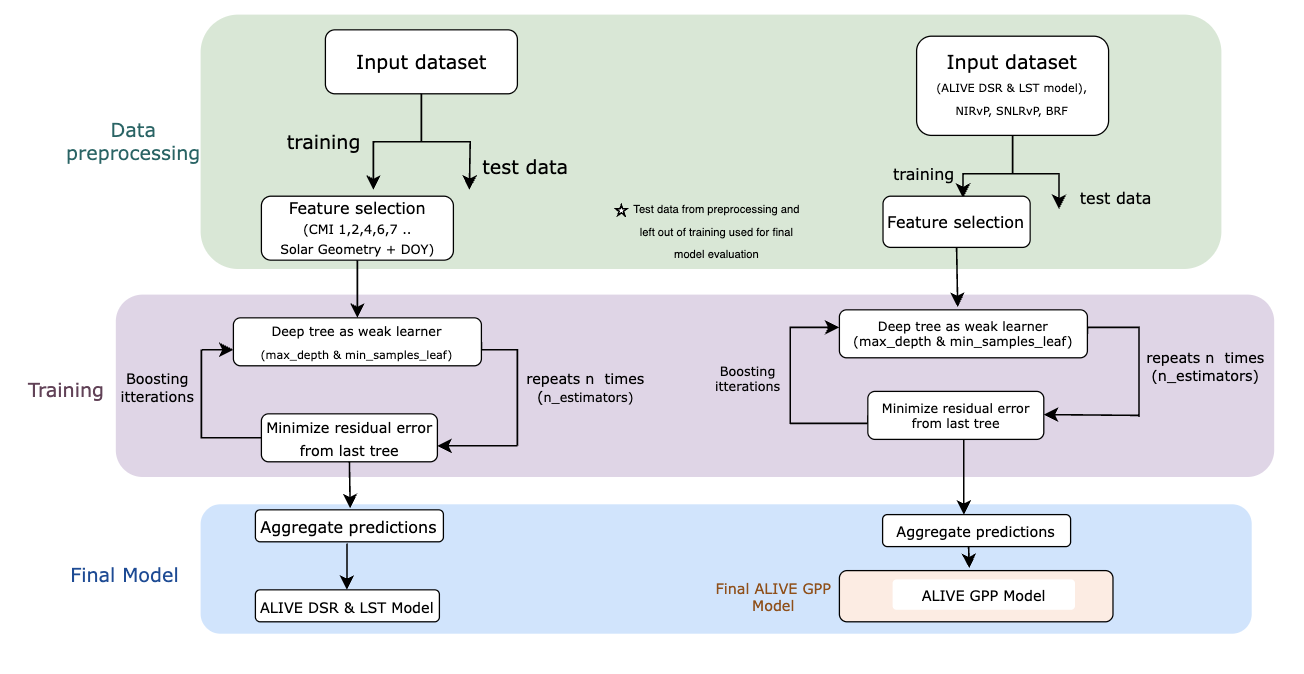

Figure 1: An example of an ALIVE workflow to estimate DSR, LST, and GPP using GBR.

# Set up

First, we will import all necessary libraries for data analysis and processing, plotting, machine learning, and more for this lesson.

In [84]:
#scikit-learn is an open-source machine learning library that we will use to preprocess data and create models
#functions to preprocess data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
#functions to create models
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neural_network import MLPRegressor
#to format our data in arrays and dataframes
import numpy as np
import pandas as pd
#statistic calculation functions
from scipy.stats import gaussian_kde
from scipy.stats import ttest_ind
#miscellaneous
import os.path
import random
import multiprocessing
#libraries for loading and storing models
import pickle
from joblib import Parallel, delayed
import joblib
#libraries for ploting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

import lightgbm as lgb
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.layers import Dropout
from concurrent.futures import ThreadPoolExecutor
import concurrent
#libraries for dates/times
import datetime
import calendar
import time
#initializing start date using datetime module
current_date = datetime.date.today()

### Importing CSV files from Github

We need to import data hosted on Github to train our machine leanring models. You can directly import  [('scrape')](https://en.wikipedia.org/wiki/Web_scraping) the .csv files from a GitHub repository into your Colab session.


For this exercise we will work with data from only three ecosystems: an evergreen needleleaf forest in the Rocky Mountains abbreviated ['xRM'](https://ameriflux.lbl.gov/sites/siteinfo/US-xRM), a deciduous forest in Virginia abbreviated ['xML'](https://ameriflux.lbl.gov/sites/siteinfo/US-xML), and a wetland in California abbreviated ['Tw4'](https://ameriflux.lbl.gov/sites/siteinfo/US-xML).

These data include eddy covariance amd micrometeorological measurements, and GOES-R observations from pixels where eddy covariance towers are located as described in [Losos et al. (2024)](https://www.nature.com/articles/s41597-024-03071-z).

In [85]:
xRM = pd.read_csv('https://raw.githubusercontent.com/paulstoy/teaching-data/refs/heads/main/subset_xRM.csv')
xML = pd.read_csv('https://raw.githubusercontent.com/paulstoy/teaching-data/refs/heads/main/subset_xML.csv')
Tw4 = pd.read_csv('https://raw.githubusercontent.com/paulstoy/teaching-data/refs/heads/main/subset_Tw4.csv')
#SiteData = xRM
SiteData = pd.concat([xRM, xML, Tw4])

# ALIVE DSR


## Data Preperation

We need to split data into training and testing subsets for machine learning, to understand how well our model works when presented with data that it was not trained upon.

The model learns to adjust its predictions from studying the training data. The test data is used to calculate error metrics that we use to evaluate the model. In our use of machine learning models, leaving out a sample of data not used in training allows the model to be generalized so that it can be used on new sites.

test_size = 0.4 indicates that 40% of the original data will be set aside for testing and the remaining 60% of data will be used for training.

The first step in estimating DSR involves selecting features to use as model inputs. We have selected several of the 16 spectral bands contained in the GOES-R Cloud and Moisture Imagery product (CMI_C[01-16]) as well as solar positional data SZA and SAA as  ALIVE_DSR_inputs. A description of all variables can be found [here](https://docs.google.com/document/d/1mMOCl9_L3RsUgMxQQbg7p73yzyc2J1Ugts_hJtgwY34/edit?tab=t.0).

CMI bands are solar reflectances and emitted radiation at various wavelengths. SZA and SAA represent solar zenith angle and solar azimuth angle respectively. These are measurements of the sun's angle at a given moment and will help us predict the amount of incoming solar radiation, while the CMI bands give insight on how various clouds filter or reflect sunlight and affect the total amount of sunlight reaching the Earth's surface, i.e. DSR.

In [86]:
ALIVE_DSR_input = ['CMI_C01', 'CMI_C02', 'CMI_C04', 'CMI_C06', 'CMI_C12', 'CMI_C15', 'SZA', 'SAA']
All_Features_DSR = ['CMI_C01', 'CMI_C02', 'CMI_C04', 'CMI_C06', 'CMI_C12', 'CMI_C15', 'SZA', 'SAA', 'SW_IN']

SiteData_sub = SiteData[All_Features_DSR]
SiteData_sub_clean = SiteData_sub.dropna()
train_data, test_data = train_test_split(SiteData_sub_clean, test_size=0.4, shuffle=True)

print('done', 'train data shape:', train_data.shape)
#combining all test data
test_data_all= pd.concat([test_data])

done train data shape: (33732, 9)


## Creating the DSR Model
Now we will create the ALIVE_DSR model to estimate SW_IN (shortwave infrared radiation, the Ameriflux abbreviation for DSR). Again, we are predicting the amount of sunlight that is needed to estimate GPP. When initializing the DSR model, we pass the Gradient Boosting Regressor (GBR) 4 different hyperparameters (n_nestimators, max_depth, learning_rate, and min_samples_leaf). Read more about these parameters [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#data-preprocessing).

We can create a model with a single line of code by calling the function *GradientBoostingRegressor* from sklearn.

Whenever we create a model, we need to fit it with our training data. Remember how we split 60% of our dataset to be used for training and 40% for testing? We will now define the columns with our features in the training and test sets as X_train and X_test, and our target variable (what we are trying to predict) as the SW_IN column in the training and test data as *y_train* and *y_test*. When fitting, you pass the model the variables *X_train* and *y_train* from the training dataset.

In [87]:
#split data
X_train = train_data[ALIVE_DSR_input]
y_train = train_data['SW_IN']
X_test = test_data[ALIVE_DSR_input]
y_test = test_data['SW_IN']

#create GBR model
DSR_model = GradientBoostingRegressor(n_estimators=200, max_depth=8, learning_rate=0.05, min_samples_leaf=300)

#fit model
DSR_model.fit(X_train, y_train)
Alive_dsr_model = DSR_model

Now that we have created the ALIVE_DSR model, we want to evaluate it. The test data (40% of data separate from the training data) will be used to quantify how 'good' the machine learning model is. The coefficient of determination (r$^2$) and root mean square error (RMSE) are common metrics to explain how well the model fits the data. Using another sklearn function, *predict*, we can call the model to create predictions and compare those values to the true target variables from the train and test sets.

[(r$^2$)](https://en.wikipedia.org/wiki/Coefficient_of_determination): How much variance can be explained by the model. A value of 1 corresponds to a perfect model.

[(RMSE)](https://en.wikipedia.org/wiki/Root_mean_square_deviation): Average magnitude of prediction errors. A value of 0 corresponds to a perfect model.

Because the model has created its predictions using the training data, it will have better error metrics compared to the test data. Think of this as scoring better on a test you have already taken compared to a new version of that test.

In [88]:
# Training set
y_train_pred = DSR_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
# Testing set
y_test_pred = DSR_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))

y_test_sites = test_data_all['SW_IN']

print(f'Training (R2={train_r2:.3f}, RMSE={train_RMSE:.3f})')
print(f'Testing (R2={test_r2:.3f}, RMSE={test_RMSE:.3f})')

Training (R2=0.944, RMSE=67.316)
Testing (R2=0.933, RMSE=73.750)


# ALIVE LST
Land surface temperature is another variable we will predict using a GBR ML model. We will then use the land surface temperature predictions as inputs for our final model that will predict gross primary productivity.

First, we will clean and modify our data by removing outliers and adding a column called *LST_tower* where we will store land surface temperature (Kelvin) values that we calculate.

The *igbp_emissivity_lookup* table will allow us to retrieve a measure of how effective a land cover category is at emitting infrared radiation. It connects the longwave radiation that ecosystems emit with their temperature through the Stefan-Boltzmann equation:

LW_OUT = $\sigma\epsilon$LST$^4$

where $\sigma$ is the Stefan-Boltzmann constant and $\epsilon$ is emissivity. Different objects have different emissivity, so different ecosystem types have different emissivities. These can be approximated by creating a lookup table and creating a function, called *estimate_emissivity_igbp*, to calculate the values of *LST_tower*.

In [89]:
# Emissivity lookup table for specific IGBP land cover categories
igbp_emissivity_lookup = {
    'Evergreen Needleleaf Forests': 0.97,
    'Deciduous Broadleaf Forests': 0.98,
    'Grasslands': 0.97,
    'Closed Shrublands': 0.95,
    'Croplands': 0.98,
    'Open Shrublands': 0.95,
    'Permanent Wetlands': 0.98,
    'Woody Savannas': 0.96,
    'Cropland/Natural Vegetation Mosaics': 0.97,
    'Mixed Forests': 0.97,
    'Savannas': 0.96,
    'Barren Sparse Vegetation': 0.92,
    'Evergreen Broadleaf Forests': 0.98
}

def estimate_emissivity_igbp(land_cover_type, anisotropy_factor=1.0):
    """
    Estimate emissivity based on IGBP land cover type and anisotropy factor.

    Parameters:
    - land_cover_type (str): The type of land cover (IGBP category).
    - anisotropy_factor (float): The anisotropy factor to adjust emissivity (default is 1.0).

    Returns:
    - emissivity (float): The estimated emissivity.
    """
    base_emissivity = igbp_emissivity_lookup.get(land_cover_type, 0.98)  # Default to 0.98 if type not found
    effective_emissivity = base_emissivity * anisotropy_factor
    return effective_emissivity


## Creating LST column and splitting data

We will now apply the esitmate_emissivity_igbp function to include emissivity values that are further used to calculate LST using the formula.

In [90]:
ALIVE_LST_input = ['CMI_C07', 'CMI_C10','CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'SZA', 'SAA', 'DOY']

Fulligbp_land_cover_type = SiteData['Vegetation (IGBP)'].unique()[0]
igbp_land_cover_type = Fulligbp_land_cover_type.split(':')[0].strip()
anisotropy_factors = 1.0

igbp_emissivity = estimate_emissivity_igbp(igbp_land_cover_type, anisotropy_factors)
print(f"Land cover: {igbp_land_cover_type}, Anisotropy factor: {anisotropy_factors}, Estimated Emissivity: {igbp_emissivity:.3f}")

DF_clean = SiteData.copy()
DF_clean['emissivity'] = igbp_emissivity

#calculating LST with formula
SBconstant = 5.67e-8
LST4 = (1/(DF_clean['emissivity']*SBconstant))*(DF_clean['LW_OUT'] - (1-DF_clean['emissivity'])*DF_clean['LW_IN'])
LST = LST4**0.25
DF_clean['LST_tower'] = LST

All_Features_LST = ['CMI_C07', 'CMI_C10','CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'SZA', 'SAA', 'DOY', 'LST_tower']
SiteData_sub = DF_clean[All_Features_LST]
SiteData_sub_clean = SiteData_sub.dropna()
train_data, test_data = train_test_split(SiteData_sub_clean, test_size=0.4, shuffle=True)

print('done', 'train data shape:', train_data.shape)

test_data_all= pd.concat([test_data])

Land cover: ENF, Anisotropy factor: 1.0, Estimated Emissivity: 0.980
done train data shape: (34042, 12)


##Creating LST Model


Now that we have calculated LST from LW_OUT observations, we can train a model for LST in the same way we did for DSR.

In [91]:
LST_aim = 'LST_tower'

print(ALIVE_LST_input)
X_train = train_data[ALIVE_LST_input]
print(X_train.shape)
y_train = train_data[LST_aim]
X_test = test_data[ALIVE_LST_input]
y_test = test_data[LST_aim]

# GBR Modeling
Alive_LST_model_gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=10, min_samples_leaf=200,
                                  subsample=0.3, max_features=0.7,
                                  learning_rate=0.01)

Alive_LST_model_gbr.fit(X_train, y_train)
#file_path = '/content/drive/MyDrive/ALIVE_ML_Tutorial/' + 'LST_GBR_'+str(current_date) + '.pkl'
#joblib.dump(Alive_LST_model_gbr, file_path)
#joblib.dump(Alive_LST_model_gbr, 'LST_GBR_'+str(current_date)+'.pkl')

# Training set
y_train_pred = Alive_LST_model_gbr.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
# Testing set
y_test_pred = Alive_LST_model_gbr.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))

y_test_sites = test_data_all[LST_aim]

print(f'Training (R2={train_r2:.3f}, RMSE={train_RMSE:.3f})')
print(f'Testing (R2={test_r2:.3f}, RMSE={test_RMSE:.3f})')
print(Alive_LST_model_gbr.feature_importances_)


['CMI_C07', 'CMI_C10', 'CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'SZA', 'SAA', 'DOY']
(34042, 11)
Training (R2=0.861, RMSE=3.650)
Testing (R2=0.853, RMSE=3.762)
[0.42359897 0.0523967  0.05134517 0.03698013 0.16597448 0.03908954
 0.01261178 0.02070971 0.04014668 0.00999397 0.14715287]


# ALIVE GPP

Now that we have our models to estimate the DSR and LST values (*ALIVE DSR and ALIVE LST*), we will add them as inputs for the final machine learning model, ALIVE GPP. Additionally, we will use known formulas to estimate two variables that are related to canopy photosynthesis, NIRvP (NDVI multiplied by reflection in the near infrared and DSR) and sNIRvP (like NIRvP but adding shortwave infrared as well). These features are vegetation band indices that are used as proxies for estimating GPP.

## read and prepare data for GPP GBR model




In [92]:
ALIVE_DSR_input = ['CMI_C01', 'CMI_C02', 'CMI_C04', 'CMI_C06', 'CMI_C12', 'CMI_C15', 'SZA', 'SAA']
ALIVE_LST_input = ['CMI_C07', 'CMI_C10','CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'SZA', 'SAA', 'DOY']
ALIVE_GPP_input = ['BRF1', 'BRF2', 'BRF3', 'BRF5', 'BRF6', 'ALIVE NIRvP', 'ALIVE sNIRvP', 'ALIVE DSR', 'ALIVE LST']

All_Features_GPP = ALIVE_LST_input + ['CMI_C01', 'CMI_C02', 'CMI_C04', 'CMI_C06'] + ['BRF1', 'BRF2', 'BRF3', 'BRF5', 'BRF6', 'GPP_np']
SiteData_sub = SiteData[All_Features_GPP]
data = SiteData_sub.dropna()


There are some missing data points in our set. Code under the comments Option 1 and Option 2 are two different ways to handle missing values. By default, the code will execute Option 1, which will remove rows with missing values. Option 2 will replace missing values with the mean value of that variable. This is called imputing and can be executed by commenting out the code under Option 1 and uncommenting the code under Option 2.

In [93]:
# Predict intermediate variables
data['ALIVE DSR'] = (Alive_dsr_model.predict(data[ALIVE_DSR_input])) / 1200
data['ALIVE LST'] = (Alive_LST_model_gbr.predict(data[ALIVE_LST_input])) / 350

# NIRvP and sNIRvP calculations
data['ALIVE NIRvP'] = ((data['BRF3'] - data['BRF2']) / (data['BRF3'] + data['BRF2'])) * data['BRF3'] * data['ALIVE DSR']
data['ALIVE sNIRvP'] = (((data['BRF3'] - data['BRF2']) / (data['BRF3'] + data['BRF2'])) * ((data['BRF3'] - data['BRF6']) / (data['BRF3'] + data['BRF6']))) * data['BRF3'] * data['ALIVE DSR']

# Impute or drop missing values before splitting
# Option 1: Drop rows with any missing values
data.dropna(inplace=True)

# Option 2: Impute missing values using SimpleImputer
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean') # or other strategy like 'median'
# data[ALIVE_GPP_input] = imputer.fit_transform(data[ALIVE_GPP_input])

train_data, test_data = train_test_split(data, test_size=0.4, shuffle=True)
ALIVE_GPP_input = ['BRF1', 'BRF2', 'BRF3', 'BRF5', 'BRF6', 'ALIVE NIRvP', 'ALIVE sNIRvP', 'ALIVE DSR', 'ALIVE LST']

test_data_all= pd.concat([test_data])

X_train = train_data[ALIVE_GPP_input]
y_train = train_data['GPP_np']
X_test = test_data[ALIVE_GPP_input]
y_test = test_data['GPP_np']


<ipython-input-93-99f0b98000f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ALIVE DSR'] = (Alive_dsr_model.predict(data[ALIVE_DSR_input])) / 1200
<ipython-input-93-99f0b98000f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ALIVE LST'] = (Alive_LST_model_gbr.predict(data[ALIVE_LST_input])) / 350
<ipython-input-93-99f0b98000f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [94]:
Alive_GPP_model = GradientBoostingRegressor(n_estimators=500, max_depth=10, min_samples_leaf=200,
                                            subsample=0.4, max_features=0.7, learning_rate=0.05)
Alive_GPP_model.fit(X_train, y_train)
y_train_pred = Alive_GPP_model.predict(X_train)

# Make predictions on training sets for GOES features
train_r2 = r2_score(y_train, y_train_pred)
train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Make predictions on testing sets for GOES features
y_test_pred = Alive_GPP_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Training Data (R2={:.3f}, RMSE={:.3f})'.format(train_r2, train_RMSE))
print('Testing Data (R2={:.3f}, RMSE={:.3f})'.format(test_r2, test_RMSE))

y_test_sites = test_data_all['GPP_np']

Training Data (R2=0.770, RMSE=4.513)
Testing Data (R2=0.719, RMSE=4.917)


#Visualizing True Values vs Predictions

## Split data and create model
The features of this model are different from the previous models in that we will include the 'UTC_TIME' column. This is because later on we will plot the true GPP values against the ALIVE predictions from the GBR model. This model is only used for visualization purposes only (not used for final model evaluation).

In [95]:

SiteData = xRM

All_Features_GPP = ['UTC_TIME'] + ALIVE_LST_input + ['CMI_C01', 'CMI_C02', 'CMI_C04', 'CMI_C06'] + ['BRF1', 'BRF2', 'BRF3', 'BRF5', 'BRF6', 'GPP_np']
SiteData_sub = SiteData[All_Features_GPP]
data_vis = SiteData_sub.dropna()

# Using ALIVE_DSR and ALIVE_LST models to create inputs for ALIVE_GPP model
data_vis['ALIVE DSR'] = (Alive_dsr_model.predict(data_vis[ALIVE_DSR_input])) / 1200
data_vis['ALIVE LST'] = (Alive_LST_model_gbr.predict(data_vis[ALIVE_LST_input])) / 350

# #formulas for calculating NIRvP and SNIRvP
data_vis['ALIVE NIRvP'] = ((data_vis['BRF3'] - data_vis['BRF2']) / (data_vis['BRF3'] + data_vis['BRF2'])) * data_vis['BRF3'] * data_vis['ALIVE DSR']
data_vis['ALIVE sNIRvP'] = (((data_vis['BRF3'] - data_vis['BRF2']) / (data_vis['BRF3'] + data_vis['BRF2'])) * ((data_vis['BRF3'] - data_vis['BRF6']) / (data_vis['BRF3'] + data_vis['BRF6']))) * data_vis['BRF3'] * data_vis['ALIVE DSR']


train_data, test_data = train_test_split(data_vis, test_size=0.4, shuffle=True)
ALIVE_GPP_input = ['BRF1', 'BRF2', 'BRF3', 'BRF5', 'BRF6', 'ALIVE NIRvP', 'ALIVE sNIRvP', 'ALIVE DSR', 'ALIVE LST']
X_train = train_data[ALIVE_GPP_input]
y_train = train_data['GPP_np']
# Prepare inputs for model
X_test = test_data[ALIVE_GPP_input]
y_test = test_data['GPP_np']
# X_train = train_data[All_Features_GPP]
# y_train = train_data['GPP_np']


Vis_GPP_model = GradientBoostingRegressor(n_estimators=500, max_depth=10, min_samples_leaf=200,
                                             subsample=0.4, max_features=0.7, learning_rate=0.05)
Vis_GPP_model.fit(X_train, y_train)


# Make predictions on test set
y_pred = Vis_GPP_model.predict(X_test)

# Combine with date and actual GPP_np
results_df = test_data[['UTC_TIME', 'GPP_np']].copy()
results_df['GPP_pred'] = y_pred

print(results_df.head())

<ipython-input-95-d4101fccb87e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_vis['ALIVE DSR'] = (Alive_dsr_model.predict(data_vis[ALIVE_DSR_input])) / 1200
<ipython-input-95-d4101fccb87e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_vis['ALIVE LST'] = (Alive_LST_model_gbr.predict(data_vis[ALIVE_LST_input])) / 350
<ipython-input-95-d4101fccb87e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

                         UTC_TIME    GPP_np  GPP_pred
18237  2023-09-29 21:00:20.800000  8.014994  8.538710
5800   2022-04-29 16:00:20.700000  4.888910  2.105193
9452   2022-09-28 20:00:20.700000  4.437690  6.599156
5254   2022-04-06 22:00:20.300000  0.282079  2.239866
14445  2023-04-24 21:00:20.400000  6.950950  5.159164


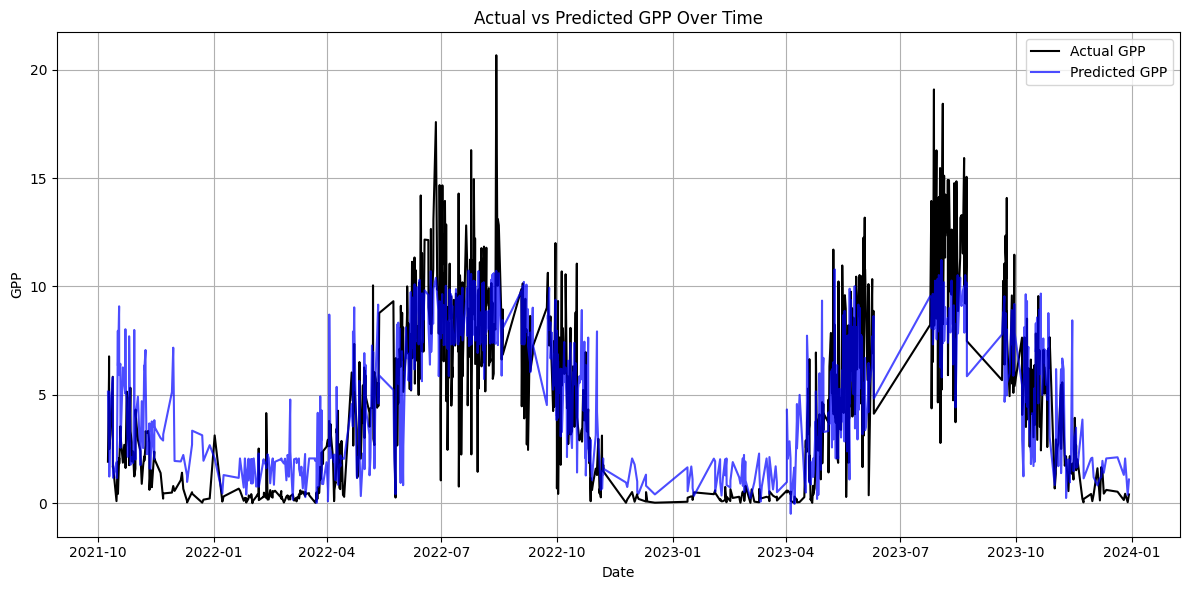

In [96]:
 # Make sure 'UTC_TIME' is in datetime format
results_df['UTC_TIME'] = pd.to_datetime(results_df['UTC_TIME'],format='mixed')

# Sort by date (optional but usually makes the plot cleaner)
results_df = results_df.sort_values('UTC_TIME')

plt.figure(figsize=(12, 6))
plt.plot(results_df['UTC_TIME'], results_df['GPP_np'], label='Actual GPP', color='black')
plt.plot(results_df['UTC_TIME'], results_df['GPP_pred'], label='Predicted GPP', color='blue', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('GPP')
plt.title('Actual vs Predicted GPP Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ALIVE Prediction

Finally, we will save each model to our drive

In [97]:
ALIVE_DSR_input = ['CMI_C01', 'CMI_C02', 'CMI_C04', 'CMI_C06', 'CMI_C12', 'CMI_C15', 'SZA', 'SAA']
ALIVE_LST_input = ['CMI_C07', 'CMI_C10','CMI_C11', 'CMI_C12', 'CMI_C13', 'CMI_C14', 'CMI_C15', 'CMI_C16', 'SZA', 'SAA', 'DOY']
ALIVE_GPP_input = ['BRF1', 'BRF2', 'BRF3', 'BRF5', 'BRF6', 'ALIVE NIRvP', 'ALIVE sNIRvP', 'ALIVE DSR', 'ALIVE LST']

### read GOES data for prediction

In [98]:
data = test_data_all

data['ALIVE LST'] = (Alive_LST_model_gbr.predict(data[ALIVE_LST_input]))/350
data['ALIVE DSR'] = (Alive_dsr_model.predict(data[ALIVE_DSR_input]))/1200

data['ALIVE NIRvP'] = ((data['BRF3'] - data['BRF2']) / (data['BRF3'] + data['BRF2'])) * data['BRF3'] * data['ALIVE DSR']
data['ALIVE sNIRvP'] = (((data['BRF3'] - data['BRF2']) / (data['BRF3'] + data['BRF2'])) * ((data['BRF3'] - data['BRF6']) / (data['BRF3'] + data['BRF6']))) * data['BRF3']* data['ALIVE DSR']
data['ALIVE SWIRvP'] = data['ALIVE sNIRvP']

GPP_Model_input = data[ALIVE_GPP_input]

# Compute R2 and RMSE for training sets for GOES features
y_prediction = Alive_GPP_model.predict(GPP_Model_input)
r2_score = r2_score(y_test_sites, y_prediction)
rmse_score = np.sqrt(mean_squared_error(y_test_sites, y_prediction))
print('R2 score:', r2_score)
print('RMSE score:', rmse_score)





R2 score: 0.7191974426121764
RMSE score: 4.917472899850439


Lesson prepared by Avanti Kekane (avkekane@wisc.edu)